# 中文数字识别

## 说明
- 数据集来自于中科院自动化研究所，下载路径：http://www.nlpr.ia.ac.cn/databases/download/feature_data/HWDB1.1trn_gnt.zip
- 原数据集包含三千多汉字图片，本实验仅抽取中文汉字图片(即十种汉字图片)，并将图片文件相对路径、标签存储到硬盘，方便读取，具体实现见github:
- 本实验执行环境：python 3.6, tensorflow 1.15.0
- 原数据集图片大小不一，实验过程中，将所有图片转化为高32，宽64的尺寸
- 实验所用数据集包括图片2000多张，并按4:1，分为训练集、测试集
- 最终训练集准确度99%，测试集准确度91%

In [231]:
import tensorflow as tf
import math
import os
import numpy as np
import struct
from PIL import Image
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import joblib

## 加载数据集
image_files 存取了各图片的路径

label_arr 存取了各图片对标签

In [235]:
image_files = joblib.load('image_files.pkl')
label_arr = joblib.load('label_arr.pkl')

In [273]:
di

[0, 66, 5, 643, 71, 255, 2, 253, 52, 402]

In [236]:
# 将各路径中的图片整合到数组中
def getDataSet(image_files, label_arr):
    X = []
    number = len(image_files)
    for image_path in image_files:
        image = Image.open(image_path)
        image = image.resize((64,32))
        image = np.array(image) / 255
        image = image.astype(np.float32)
        assert(np.shape(image) == (32,64,3))
        X.extend(image.reshape(-1))
    X = np.array(X)
    X = X.reshape((number,32,64,3))
    Y = np.eye(11)[label_arr]
    return X, Y

In [237]:
X, Y = getDataSet(image_files,label_arr)
print(X.shape)
print(Y.shape)

## 划分数据集
将原数据集打乱，按4:1，分为训练集、测试集 

In [197]:
np.random.seed(42)
m = X.shape[0]
train_size = int(m*0.8)
permutation = list(np.random.permutation(m))
shuffled_X = X[permutation,:,:,:]
shuffled_Y = Y[permutation,:]
X_train = shuffled_X[:train_size,:,:,:]
X_test = shuffled_X[train_size:,:,:,:]
Y_train = shuffled_Y[:train_size,:]
Y_test = shuffled_Y[train_size:,:]
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (1911, 32, 64, 3)
Y_train shape: (1911, 11)
X_test shape: (478, 32, 64, 3)
Y_test shape: (478, 11)


y = 2


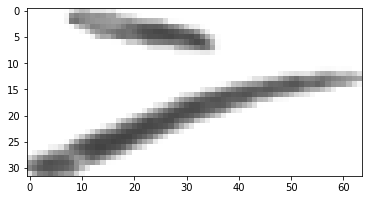

In [198]:
# 根据index查看图片
index = 1000
plt.imshow(X_train[index])
print("y = " + str(np.argmax(Y_train[index])))

## 构建卷积神经网络

我们的网络构成：
1. 卷积层1, 4x4的8个filter，same padding，激活函数用Relu
2. 最大池化层1，8x8的filter，步长为8，samepadding
3. 卷积层2，2x2的16个filter，same padding，激活函数用Relu
4. 最大池化层2，4x4的filter，步长为4, samepadding
5. 卷积层3，2x2的32个filter，same padding，激活函数用Relu
6. 最大池化层2，2x2的filter，步长为2, samepadding
7. 全连接层

In [199]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])
    return X, Y

In [241]:
def initialize_parameters():
    tf.set_random_seed(1) 
    W1 = tf.get_variable("W1",  [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",  [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3",  [2, 2, 16, 32], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}
    
    return parameters

In [265]:
def forward_propagation(X, parameters):

    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME")
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding="SAME")
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding="SAME")
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
    # CONV2D: filters W3, stride 1, padding 'SAME'
    Z3 = tf.nn.conv2d(P2, W3, strides=[1,2,2,1], padding="SAME")
    # RELU
    A3 = tf.nn.relu(Z3)
    # MAXPOOL: window 2x2, stride 2, padding 'SAME'
    P3 = tf.nn.max_pool(Z3, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    # FLATTEN
    P3 = tf.contrib.layers.flatten(P3)
    #fully connected
    Z4 = tf.contrib.layers.fully_connected(P3, 11, activation_fn=None, weights_initializer=tf.contrib.layers.xavier_initializer(seed=0))

    return Z4

In [257]:
def compute_cost(Z3, Y):
    cost = tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y)
    cost = tf.reduce_mean(cost)
    return cost

In [258]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [263]:

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 50, minibatch_size = 32):

    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()

    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    saver = tf.train.Saver()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y}) 
                minibatch_cost += temp_cost / num_minibatches
                
            # Print the cost every epoch
            if  epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if  epoch % 1 == 0:
                costs.append(minibatch_cost)
            # save parameters
            if epoch == num_epochs-1:
                saver.save(sess,'params.ckpt')
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.264223
Cost after epoch 5: 0.368600
Cost after epoch 10: 0.264768
Cost after epoch 15: 0.094297
Cost after epoch 20: 0.135389
Cost after epoch 25: 0.105475
Cost after epoch 30: 0.118863
Cost after epoch 35: 0.038662
Cost after epoch 40: 0.112643
Cost after epoch 45: 0.089686


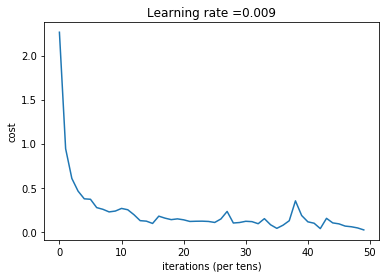

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9958137
Test Accuracy: 0.91004187


In [266]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

训练集拟合了99%，测试集准确达91%